# keras와 Pytorch비교
* make date : 2024-03-22
* revision date : 2024-03-27
* 신재호

# keras MNIST분류

In [ ]:
from keras.datasets import mnist
from keras.utils import to_categorical, Sequence
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.metrics import confusion_matrix

(X_train, y_train), (X_val, y_val) = mnist.load_data()

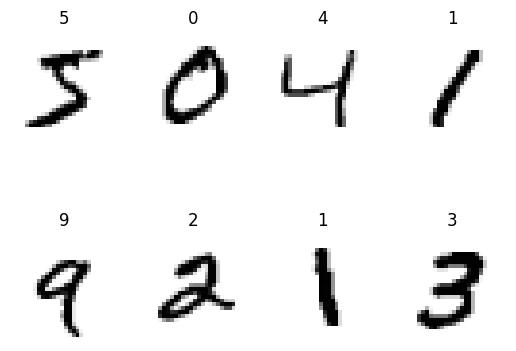

In [ ]:
for i in range(8):
  plt.subplot(2,4,i+1)
  plt.imshow(X_train[i], cmap = plt.cm.binary)
  plt.title(f'{y_train[i]}')
  plt.axis('off')

In [ ]:
X_train = X_train.reshape(-1,28,28,1)/255.
X_val = X_val.reshape(-1,28,28,1)/255.

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [ ]:
class DataLoader(Sequence):
  def __init__(self, batch_size, X, y):
    self.batch_size = batch_size
    self.X = X
    self.y = y

  def __getitem__(self, idx):
    start, end = idx * self.batch_size, (idx + 1) * self.batch_size
    return self.X[start:end], self.y[start:end]

  def __len__(self):
    return math.ceil(len(self.y)/self.batch_size)

def Simple_CNN():
  model = Sequential()
  model.add(Conv2D(32,(2,2),activation="relu",input_shape=(28,28,1)))
  model.add(BatchNormalization())
  model.add(Conv2D(64,(2,2),activation="relu"))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(128,activation = 'relu'))
  model.add(Dense(10, activation = 'softmax'))
  return model

In [ ]:
train_loader = DataLoader(32, X_train, y_train)
val_loader = DataLoader(32, X_val, y_val)


model = Simple_CNN()
model.compile(optimizer = 'SGD', loss = 'categorical_crossentropy', metrics = ['acc'])
model_checkpoint = ModelCheckpoint(monitor = 'val_loss', save_best_only = True, verbose=1,
                                   filepath = '/content/keras_CNN.keras')
history = model.fit(train_loader, validation_data = val_loader, epochs = 10, callbacks = [model_checkpoint])

Epoch 1/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.1249 - acc: 0.9621
Epoch 1: val_loss improved from inf to 0.05300, saving model to /content/keras_CNN.keras
1875/1875 [==============================] - 21s 9ms/step - loss: 0.1247 - acc: 0.9621 - val_loss: 0.0530 - val_acc: 0.9832
Epoch 2/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0234 - acc: 0.9933
Epoch 2: val_loss improved from 0.05300 to 0.04338, saving model to /content/keras_CNN.keras
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0234 - acc: 0.9933 - val_loss: 0.0434 - val_acc: 0.9856
Epoch 3/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0066 - acc: 0.9987
Epoch 3: val_loss improved from 0.04338 to 0.04105, saving model to /content/keras_CNN.keras
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0066 - acc: 0.9987 - val_loss: 0.0411 - val_acc: 0.9875
Epoch 4/10
1875/1875 [==============================] - ETA: 0s - loss: 0.

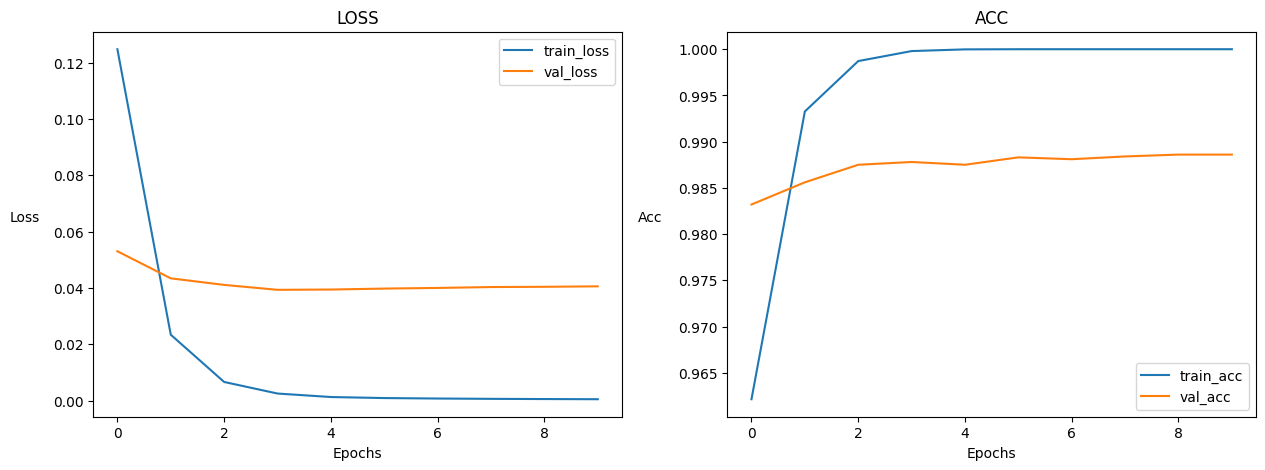

In [ ]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss', rotation = 360, labelpad = 20)

plt.subplot(1,2,2)
plt.plot(history.history['acc'], label = 'train_acc')
plt.plot(history.history['val_acc'], label = 'val_acc')
plt.legend()
plt.title('ACC')
plt.xlabel('Epochs')
plt.ylabel('Acc', rotation = 360, labelpad = 20)

plt.show()


In [ ]:
def batch_extractor(batch_no, model, loader):
  for i, data in enumerate(loader):
    x, y = data
    imgs = x
    labels = y.argmax(1)
    if i == batch_no - 1:
      break
  preds = model.predict(imgs).argmax(1)
  imgs = imgs * 255.
  imgs = imgs.astype(int)

  extract_dict = {}
  extract_dict['imgs'] = imgs
  extract_dict['labels'] = labels
  extract_dict['preds'] = preds
  return extract_dict

1/1 [==============================] - 0s 99ms/step


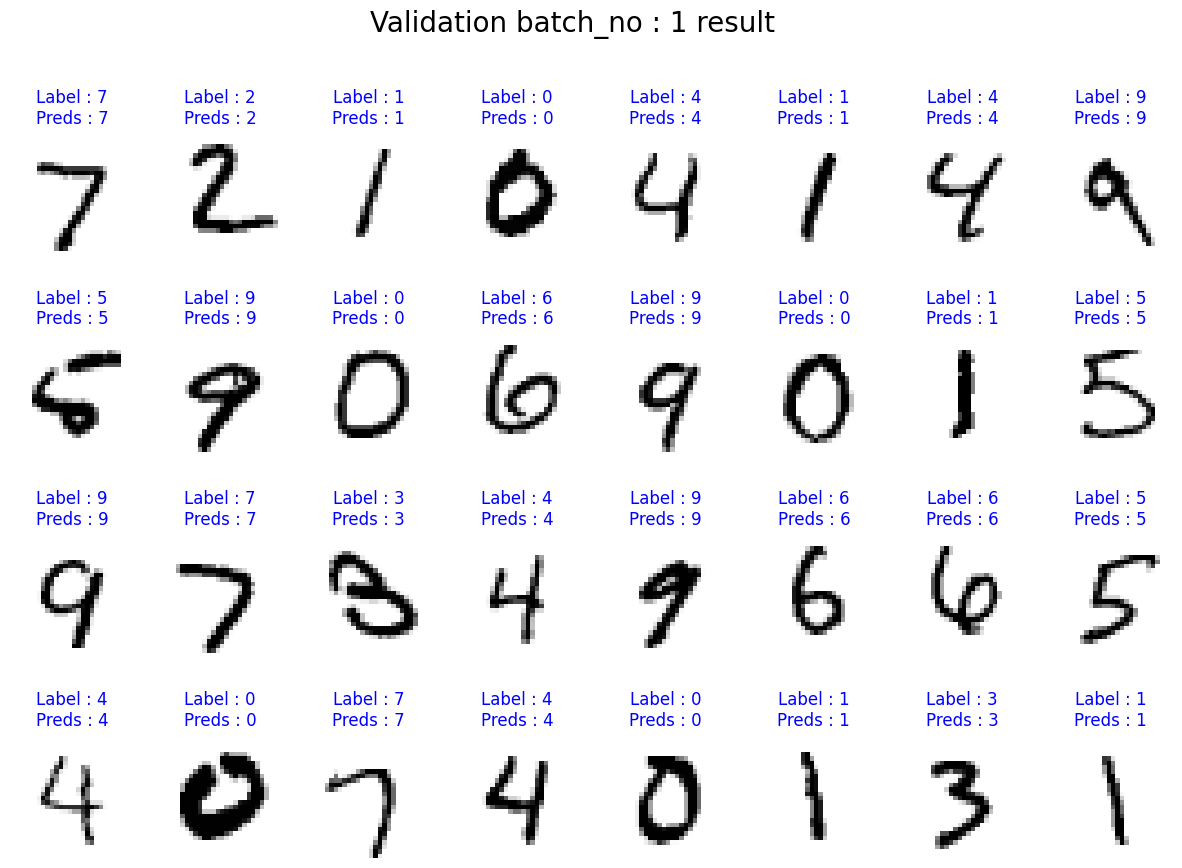

In [ ]:
batch_no = 1
extract_dict = batch_extractor(batch_no = batch_no, model = model, loader = val_loader)

plt.figure(figsize = (15,10))
for i in range(32):
  plt.subplot(4,8,i+1)
  plt.imshow(extract_dict['imgs'][i], cmap = plt.cm.binary)
  plt.axis('off')
  if extract_dict['preds'][i] == extract_dict['labels'][i]:
    color = "blue"
  else:
    color = "red"
  plt.title(f'Label : {extract_dict["labels"][i]}\nPreds : {extract_dict["preds"][i]}', color = color)
plt.suptitle(f"Validation batch_no : {batch_no} result", fontsize = 20)
plt.show()

In [ ]:
preds = model.predict(X_val).argmax(1)
labels = y_val.argmax(1)

conf_array = np.zeros(10)
tmp_df = pd.DataFrame(conf_array)
conf_df = pd.DataFrame()
for i in range(10):
  conf_df = pd.concat([conf_df, tmp_df.T], axis = 0)
conf_df.index = [i for i in range(10)]

for i in range(len(preds)):
  conf_df.loc[labels[i], preds[i]] += 1
conf_df = conf_df.astype(int)
conf_df

313/313 [==============================] - 1s 2ms/step


,0,1,2,3,4,5,6,7,8,9
0,975,1,1,1,0,0,1,1,0,0
1,0,1129,2,1,0,0,2,1,0,0
2,2,1,1019,0,1,0,0,6,3,0
3,0,0,4,994,0,6,0,2,2,2
4,0,0,0,0,973,0,4,0,0,5
5,1,0,1,3,0,885,2,0,0,0
6,5,2,0,0,1,1,947,0,2,0
7,1,2,3,3,0,0,0,1013,2,4
8,3,0,3,0,0,2,1,2,960,3
9,1,2,0,4,6,2,0,2,1,991


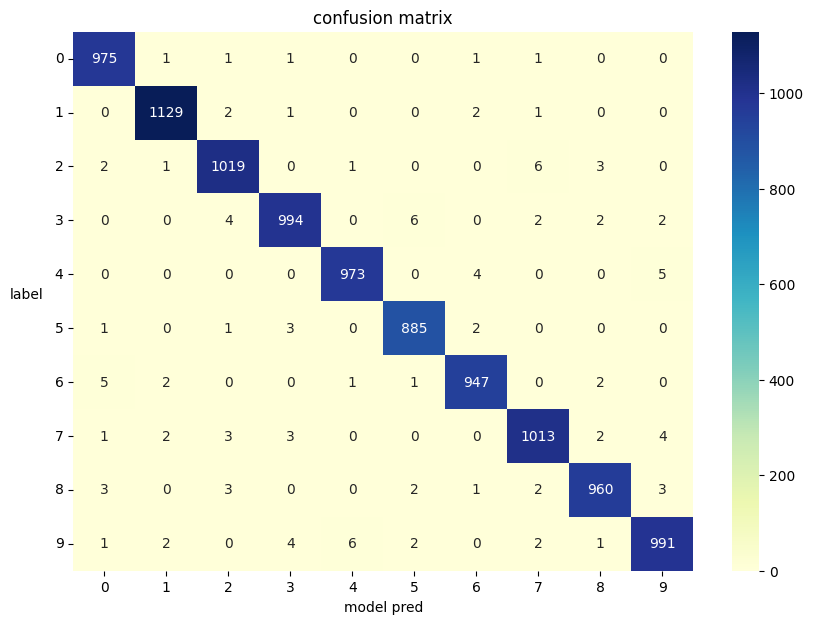

In [ ]:
plt.figure(figsize = (10,7))
sns.heatmap(conf_df, annot = True, fmt = 'd', cmap='YlGnBu')
plt.yticks(rotation = 360)
plt.xlabel('model pred')
plt.ylabel('label', rotation = 360, labelpad = 20)
plt.title('confusion matrix')
plt.show()

In [ ]:
wrong_img = []
wrong_label = []
wrong_pred = []

for i in range(len(preds)):
  if preds[i] != labels[i]:
    restore_X = X_val[i] * 255.
    wrong_img.append(restore_X.astype(int))
    wrong_label.append(labels[i])
    wrong_pred.append(preds[i])

wrong_img = np.array(wrong_img)
wrong_label = np.array(wrong_label)
wrong_pred = np.array(wrong_pred)

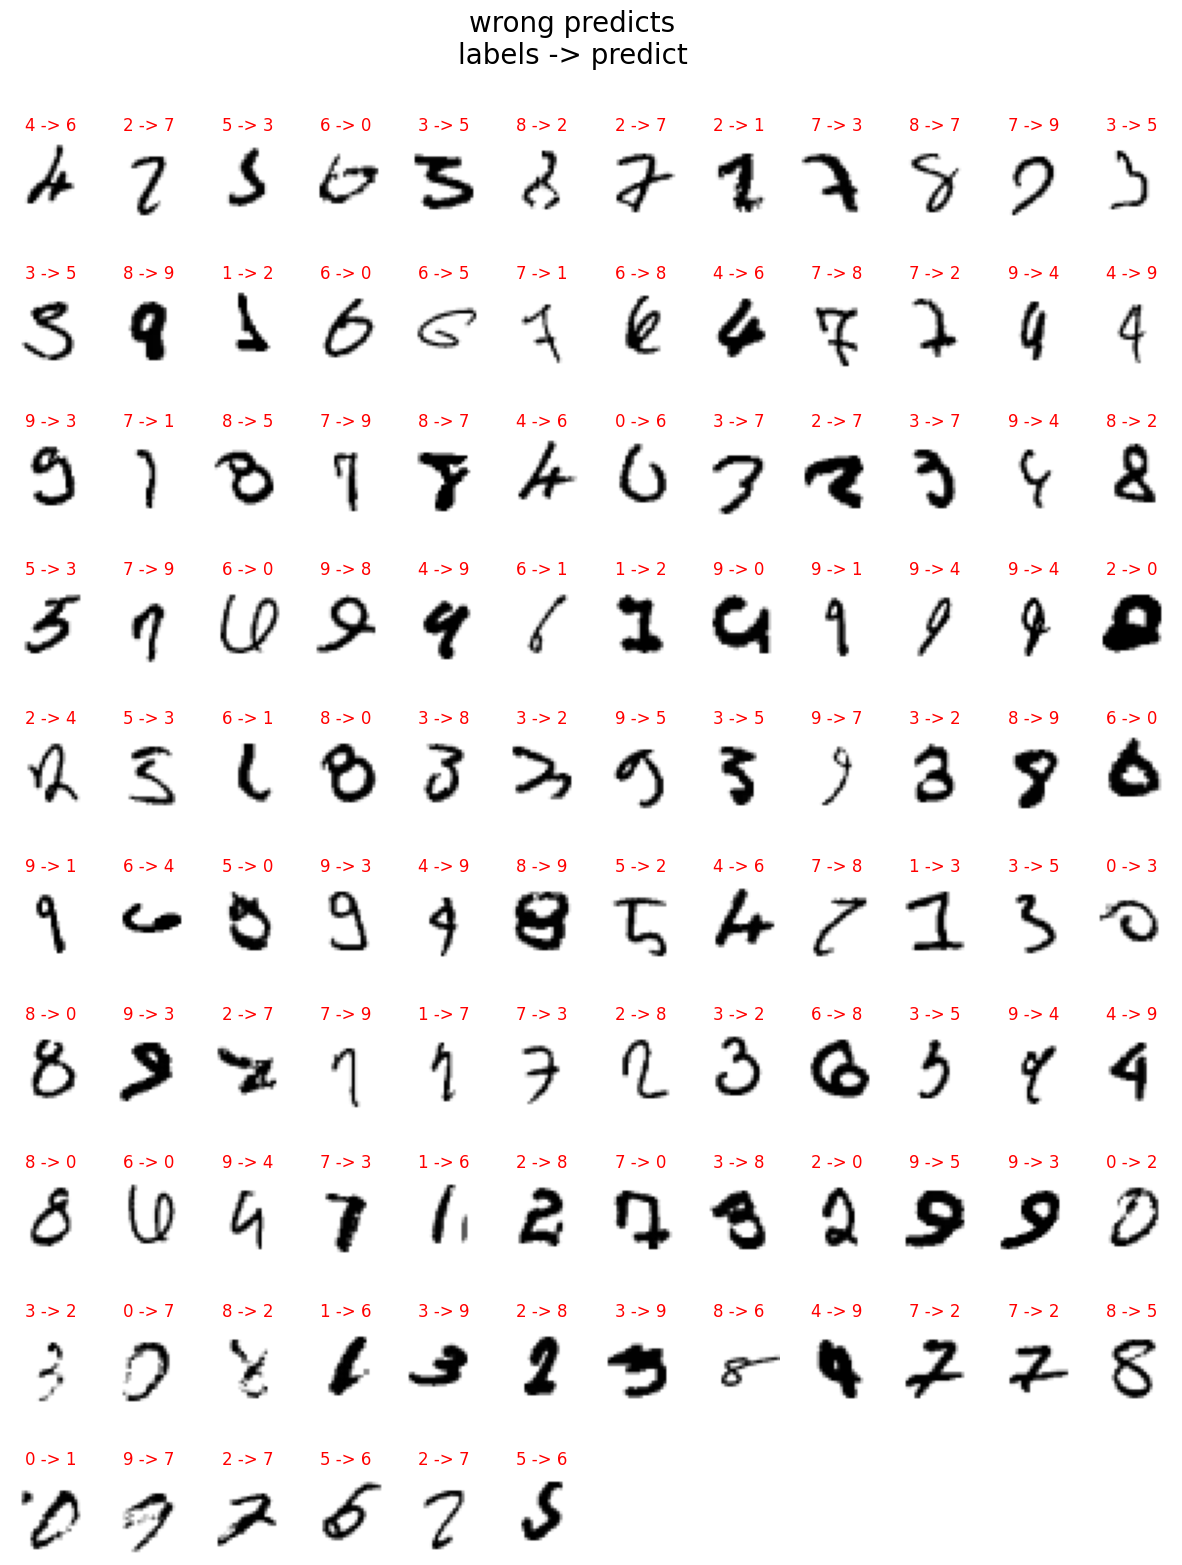

In [ ]:
plt.figure(figsize = (15,18))
for i in range(len(wrong_img)):
  plt.subplot(10, 12, i + 1)
  plt.imshow(wrong_img[i], cmap = plt.cm.binary)
  plt.axis('off')
  plt.title(f'{wrong_label[i]} -> {wrong_pred[i]}', color = "red")
plt.suptitle("wrong predicts\nlabels -> predict", fontsize = 20)
plt.subplots_adjust(top=0.92)
plt.show()

# Pytorch MNIST 분류

In [ ]:
import torch
from torch import nn
from torchvision import transforms, datasets

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
import torch
from torchvision import datasets, transforms

class CustomMNIST(datasets.MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super().__init__(root=root, train=train, transform=transform, target_transform=target_transform, download=download)

    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        return img, target

# 데이터셋 불러오기
train_dataset = CustomMNIST(root="./data/MNIST", train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    # 정규화가 되어진 이미지를 전달하기 때문에, 따로 수행하지 않아도 됨!!
    # transforms.Lambda(lambda x: x / 255.0)
]))
val_dataset = CustomMNIST(root="./data/MNIST", train=False, transform=transforms.Compose([
    transforms.ToTensor(),
    # 정규화가 되어진 이미지를 전달하기 때문에, 따로 수행하지 않아도 됨!!
    # transforms.Lambda(lambda x: x / 255.0)
]))

# 데이터로더 생성
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, drop_last=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32, drop_last=True)

In [ ]:
class Simple_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 2),
        nn.ReLU(),
        nn.BatchNorm2d(32)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 2),
        nn.ReLU(),
        nn.BatchNorm2d(64)
    )
    self.dense1 = nn.Sequential(
        nn.Linear(in_features = 64 * 26 * 26, out_features = 128),
        nn.ReLU()
    )
    # 파이토치의 nn.CrossEntropy는 softmax가 합쳐저 있으므로 따로 softmax층을 선언할 필요없음!!
    self.dense2 = nn.Linear(in_features = 128, out_features = 10)

  def forward(self, x):
    out = self.conv1(x)
    out = self.conv2(out)
    # flatten
    out = out.reshape(out.size(0), -1)
    out = self.dense1(out)
    out = self.dense2(out)
    return out

In [ ]:
def train(model, loader, criterion, optimizer):
  '''
  학습을 위한 함수
  '''
  model.train()
  train_loss = 0.
  train_acc = 0.

  for X, y in loader:

    #X = X.view(32,1,28,28)
    X = X.to(device)
    y = y.to(device)

    y_hat = model(X)
    loss = criterion(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # loss
    train_loss += loss.item()

    # acc
    pred = y_hat.max(1, keepdim = True)[1]
    train_acc += pred.eq(y.data.view_as(pred)).sum().item()

  train_loss  = train_loss / len(loader)
  train_acc = train_acc / len(loader.dataset)

  return train_loss, train_acc

def val(model, loader, criterion):
  '''
  검증을 위한 함수
  '''
  model.eval()
  val_loss = 0.
  val_acc = 0.

  with torch.no_grad():
    for X, y in loader:
      #X = X.view(32,1,28,28)
      X = X.to(device)
      y = y.to(device)

      y_hat = model(X)
      loss = criterion(y_hat, y)
      val_loss += loss.item()

      # acc
      pred = y_hat.max(1, keepdim = True)[1]
      val_acc += pred.eq(y.data.view_as(pred)).sum().item()

  val_loss  = val_loss / len(loader)
  val_acc = val_acc / len(loader.dataset)

  return val_loss, val_acc

In [ ]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

model = Simple_CNN().to(device)

epochs = 10
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
st_loss = 1000

for epoch in range(epochs):
  print(f'########### epoch : {epoch + 1} ###########')
  train_loss, train_acc = train(model, train_loader, criterion, optimizer)
  val_loss, val_acc = val(model, val_loader, criterion)
  train_loss_list.append(train_loss)
  train_acc_list.append(train_acc)
  val_loss_list.append(val_loss)
  val_acc_list.append(val_acc)
  if val_loss < st_loss:
    print(f'* train_loss = {train_loss}, train_acc = {train_acc}, val_acc = {val_acc}')
    print(f'* val_loss가 향상되었습니다. {st_loss} ==> {val_loss}')
    st_loss = val_loss
    torch.save(model.state_dict(), '/content/pytorch_CNN.pt')
  else:
    print(f'* train_loss = {train_loss}, train_acc = {train_acc}, val_acc = {val_acc}')
    print(f'* val_loss가 향상되지 않았습니다, val_loss = {val_loss}')

########### epoch : 1 ###########
* train_loss = 0.11286825434039346, train_acc = 0.9656666666666667, val_acc = 0.9776
* val_loss가 향상되었습니다. 1000 ==> 0.062422687721174534
########### epoch : 2 ###########
* train_loss = 0.02573918112757383, train_acc = 0.9932833333333333, val_acc = 0.9839
* val_loss가 향상되었습니다. 0.062422687721174534 ==> 0.04594654155108657
########### epoch : 3 ###########
* train_loss = 0.00889436214150046, train_acc = 0.9987, val_acc = 0.9841
* val_loss가 향상되었습니다. 0.04594654155108657 ==> 0.04419585755977096
########### epoch : 4 ###########
* train_loss = 0.003692691430540678, train_acc = 0.9997666666666667, val_acc = 0.9847
* val_loss가 향상되었습니다. 0.04419585755977096 ==> 0.04418670832401753
########### epoch : 5 ###########
* train_loss = 0.0020743753099639432, train_acc = 0.9999833333333333, val_acc = 0.9853
* val_loss가 향상되었습니다. 0.04418670832401753 ==> 0.04391539043130548
########### epoch : 6 ###########
* train_loss = 0.0014441323456427198, train_acc = 0.9999833333333333

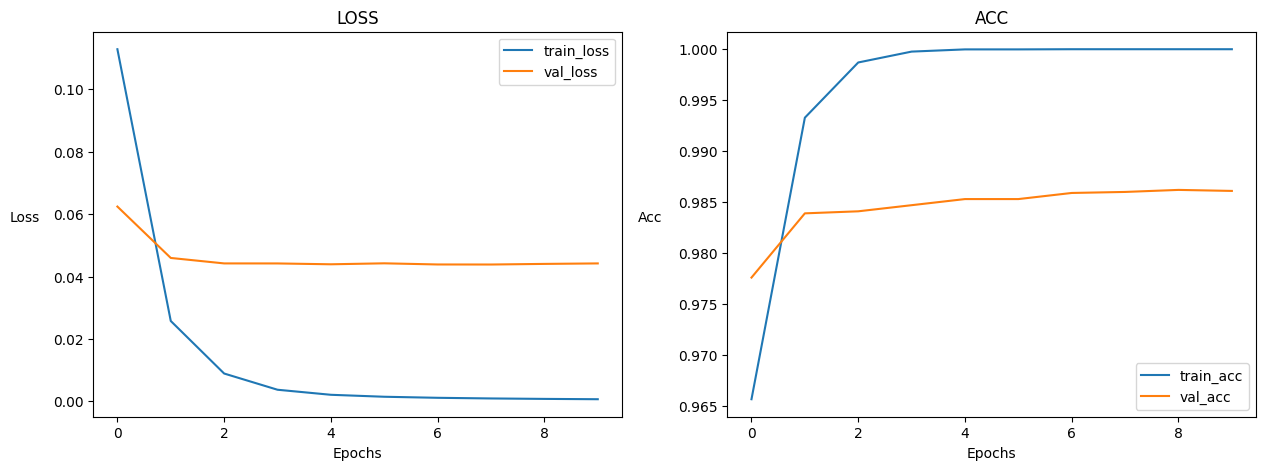

In [ ]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.plot(train_loss_list, label = 'train_loss')
plt.plot(val_loss_list, label = 'val_loss')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss', rotation = 360, labelpad = 20)

plt.subplot(1,2,2)
plt.plot(train_acc_list, label = 'train_acc')
plt.plot(val_acc_list, label = 'val_acc')
plt.legend()
plt.title('ACC')
plt.xlabel('Epochs')
plt.ylabel('Acc', rotation = 360, labelpad = 20)

plt.show()

In [ ]:
def batch_extractor(batch_no, loader, model):
  for i, data in enumerate(loader):
    x, y = data
    imgs = x.to(device)
    labels = y.numpy()
    if i == batch_no - 1:
      break
  model.eval()
  with torch.no_grad():
    preds = model(imgs).max(1, keepdim = True)[1].detach().to('cpu').numpy().reshape(-1)

  imgs = imgs.detach().to('cpu').numpy() * 255.
  imgs = np.transpose(imgs, (0,2,3,1))
  imgs = imgs.astype(int)

  extract_dict = {}
  extract_dict['imgs'] = imgs
  extract_dict['labels'] = labels
  extract_dict['preds'] = preds
  return extract_dict

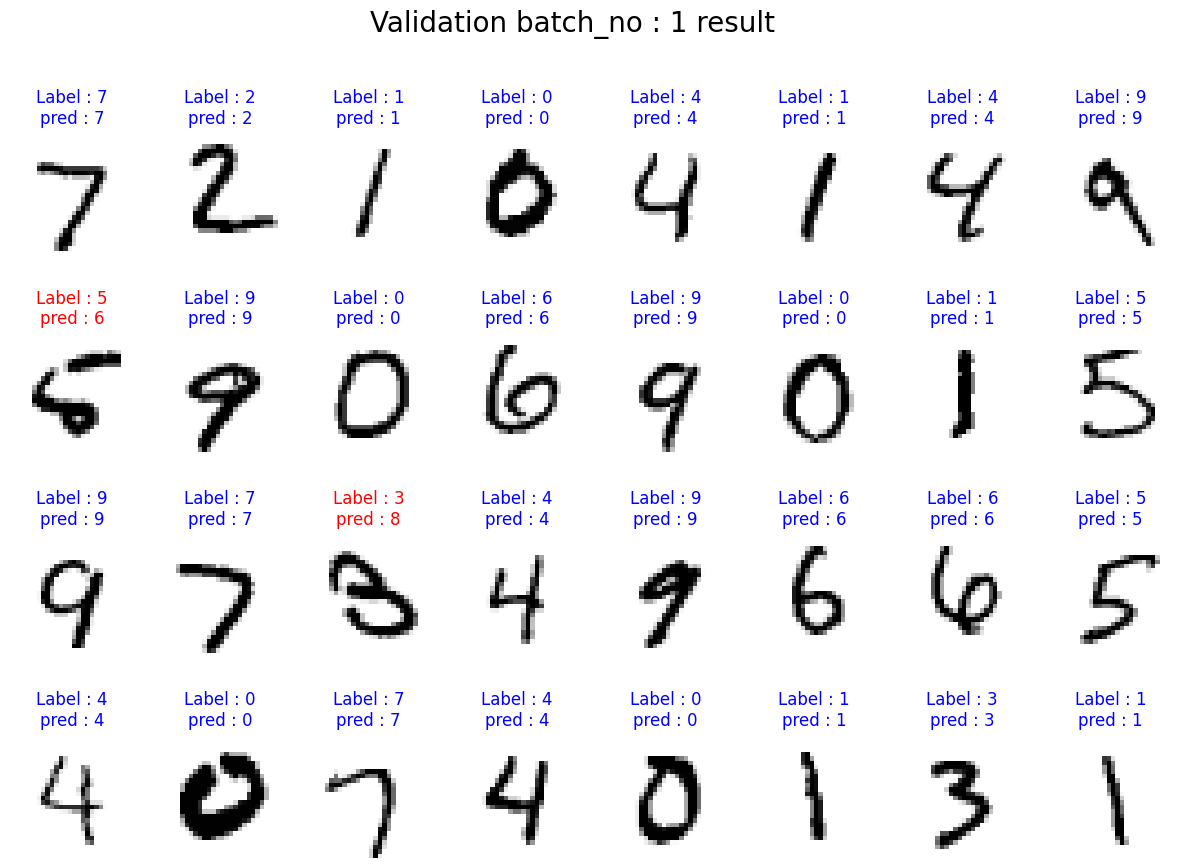

In [ ]:
batch_no = 1
extract_dict = batch_extractor(batch_no = batch_no, loader = val_loader, model = model)
plt.figure(figsize = (15,10))
for i in range(32):
  plt.subplot(4,8,i+1)
  plt.imshow(extract_dict['imgs'][i], cmap = plt.cm.binary)
  if extract_dict['preds'][i] == extract_dict['labels'][i]:
    color = "blue"
  else:
    color = "red"
  plt.title(f'Label : {extract_dict["labels"][i]}\npred : {extract_dict["preds"][i]}', color = color)
  plt.axis('off')
plt.suptitle(f'Validation batch_no : {batch_no} result', fontsize = 20)
plt.show()

In [ ]:
labels = []
preds = []

model.eval()
with torch.no_grad():
  for img, label in val_loader:
    labels.append(label.numpy())

    img = img.to(device)
    pred = model(img).max(1, keepdim = True)[1].detach().to('cpu').numpy().reshape(-1)
    preds.append(pred)

preds = np.array(preds).reshape(-1)
labels = np.array(labels).reshape(-1)

In [ ]:
tmp_df = pd.DataFrame(np.zeros(10).T)
conf_df = pd.DataFrame()
for i in range(10):
  conf_df = pd.concat([conf_df, tmp_df], axis = 1)
conf_df.index = [i for i in range(10)]
conf_df.columns = [i for i in range(10)]

for i in range(len(labels)):
  conf_df.loc[labels[i], preds[i]] += 1
conf_df = conf_df.astype(int)
conf_df

,0,1,2,3,4,5,6,7,8,9
0,975,0,1,0,0,0,2,1,0,0
1,0,1127,1,1,1,0,1,1,1,0
2,2,1,1018,0,1,0,1,4,3,0
3,0,0,0,994,0,6,0,3,4,1
4,0,0,0,0,971,0,4,0,0,5
5,2,0,1,3,0,880,4,0,0,0
6,6,2,2,0,1,1,942,0,2,0
7,0,2,5,2,0,0,0,1013,2,3
8,5,0,2,0,1,2,0,3,958,2
9,2,3,0,2,6,5,0,4,3,983


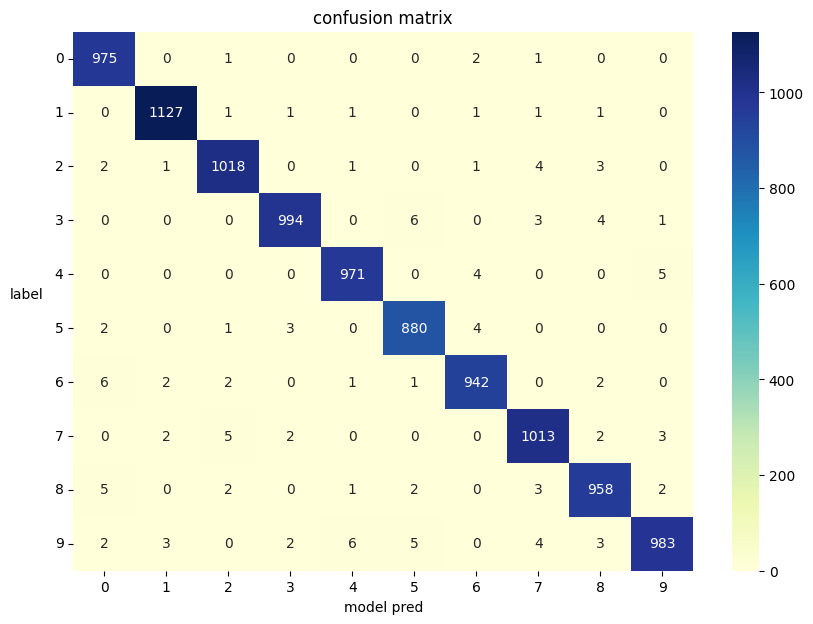

In [ ]:
plt.figure(figsize = (10,7))
sns.heatmap(conf_df, annot = True, fmt = 'd', cmap='YlGnBu')
plt.yticks(rotation = 360)
plt.xlabel('model pred')
plt.ylabel('label', rotation = 360, labelpad = 20)
plt.title('confusion matrix')
plt.show()

In [ ]:
wrong_img = []
wrong_label = []
wrong_pred = []

for data in val_loader:
  x, y = data
  imgs = x.to(device)
  labels = y.numpy()
  model.eval()
  with torch.no_grad():
    preds = model(imgs).max(1, keepdim = True)[1].detach().to('cpu').numpy().reshape(-1)
  imgs = imgs.detach().to('cpu').numpy()
  imgs = np.transpose(imgs, (0,2,3,1)) * 255.
  imgs = imgs.astype(int)

  for i in range(len(preds)):
    if preds[i] != labels[i]:
      wrong_img.append(imgs[i])
      wrong_label.append(labels[i])
      wrong_pred.append(preds[i])
wrong_img = np.array(wrong_img)
wrong_label = np.array(wrong_label)
wrong_pred = np.array(wrong_pred)

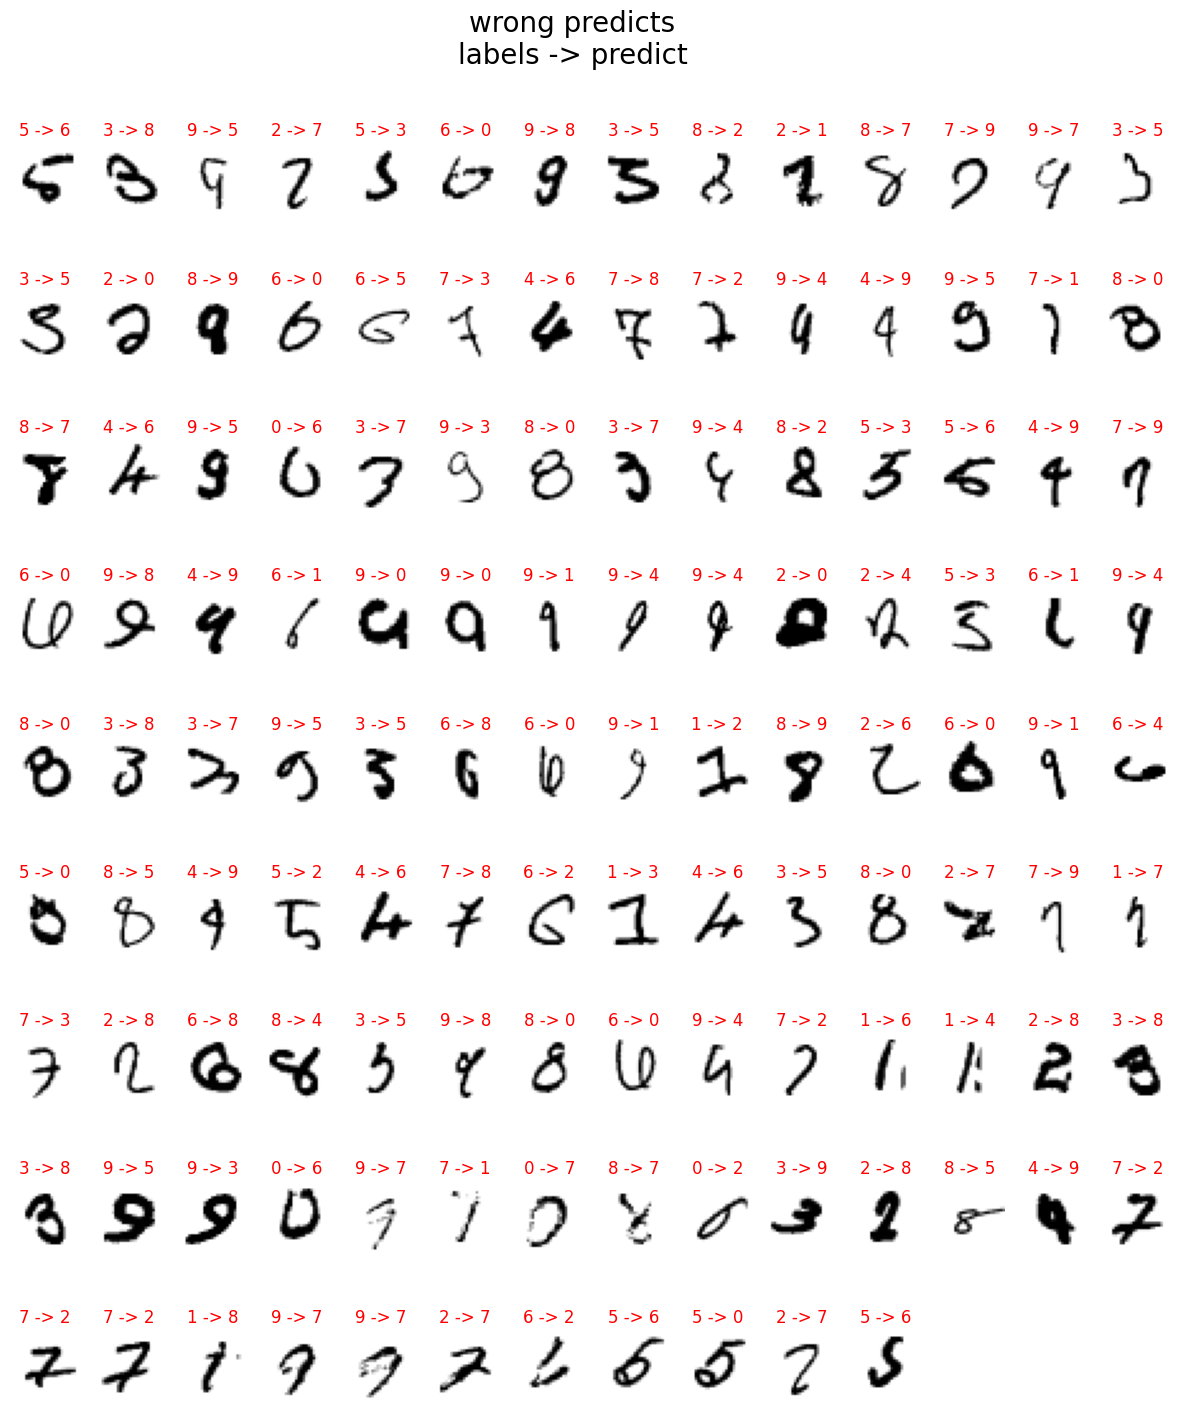

In [ ]:
plt.figure(figsize = (15,18))
for i in range(len(wrong_img)):
  plt.subplot(10, 14, i + 1)
  plt.imshow(wrong_img[i], cmap = plt.cm.binary)
  plt.axis('off')
  plt.title(f'{wrong_label[i]} -> {wrong_pred[i]}', color = "red")
plt.suptitle("wrong predicts\nlabels -> predict", fontsize = 20)
plt.subplots_adjust(top=0.92)
plt.show()

# 객체 지향

In [ ]:
class DataLoader(Sequence):
  def __init__(self, batch_size, X, y):
    self.batch_size = batch_size
    self.X = X
    self.y = y

  def __getitem__(self, idx):
    start, end = idx * self.batch_size, (idx + 1) * self.batch_size
    return self.X[start:end], self.y[start:end]

  def __len__(self):
    return math.ceil(len(self.y)/self.batch_size)

In [ ]:
class Person():
  def __init__(self, name, age):
    self.name = name
    self.age = age
    print("Person __init__ 수행")

  def work(self,hour):
    print(f"{self.name}가 {hour}시간 일을 합니다.")

class Student(Person):
  def __init__(self, name, age):
    super().__init__(name, age)
    self.name = name
    self.age = age
    print("Student __init__ 수행")

  def work(self, hour):
    super().work(hour)
    print(f"{self.name}가 {hour}시간 공부를 합니다.")

In [ ]:
p1 = Person(name = "신재호", age = 27)

Person __init__ 수행


In [ ]:
s1 = Student(name = "신재호", age = 27)

Person __init__ 수행
Student __init__ 수행


In [ ]:
class Simple_layer(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(in_features = 3, out_features = 1)

  def forward(self,x):
    return self.linear(x)

* \_\_init\_\_
* \_\_len\_\_
* \_\_getitem\_\_

In [ ]:
class List_Reader():
  def __init__(self, l1):
    self.l1 = l1

  def length_reader(self):
    return len(self.l1)

  def __len__(self):
    return len(self.l1)

  def indexer(self, idx):
    return self.l1[idx]

  def __getitem__(self,idx):
    return self.l1[idx]

In [ ]:
lr = List_Reader([1,2,3,4,5,6,7,8,9,10])

In [ ]:
lr.indexer(4)

5

* \_\_all\_\_

In [ ]:
from test import *

In [ ]:
h1 = human(name="신재호", age =27)

Person __init__ 수행


In [ ]:
a1 = animal(name = "푸", age = 3)